# Import modules

In [1]:
from __future__ import (absolute_import, division, print_function,unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
import backtrader.feeds as btfeed

# Data

In [2]:
modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
datapath = os.path.join(modpath, 'backtrader\datas\EURUSD_01-01_01-04_daily.txt')

data = btfeed.GenericCSVData(
          dataname=datapath,
#           timeframe=bt.TimeFrame.Minutes,
#           compression=60,
          fromdate = datetime.datetime(2019,1,1),
          todate=datetime.datetime(2019,4,1),                                  
          nullvalue=0.0,
          dtformat=('%Y%m%d'),
          tmformat=('%H:%M:%S'),
          datetime=0,
          time=1,
          open=2,
          high=3,
          low=4,
          close=5,
          volume=6
        )

# Strategy Class

In [3]:
# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

# Init Function

In [4]:
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        
         # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        # Add a Stochastic indicator
        self.stoch = bt.indicators.StochasticSlow(self.datas[0])
        

    

# Notify Order

In [5]:
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                        (order.executed.price,
                         order.executed.value,
                         order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                        (order.executed.price,
                         order.executed.value,
                         order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    

# Notify Trade

In [6]:
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        
        # Print out the final result
        print('Current Portfolio Value: %.2f' % cerebro.broker.getvalue())

    
    

# Next Function

In [7]:
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.4f' % self.dataclose[0])
        
        print (self.stoch.lines.percK[0])
        print (self.stoch.lines.percD[0])
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        
    
        # Not yet ... we MIGHT BUY if ...
        if self.stoch.lines.percK[-1] < self.stoch.lines.percD[-1] and self.stoch.lines.percK[0] > self.stoch.lines.percD[0]:

            # BUY, BUY, BUY!!! (with all possible default parameters)
            self.log('BUY CREATE, %.2f' % self.dataclose[0])

#             self.close()
            
            # Keep track of the created order to avoid a 2nd order
            self.order = self.buy()

        elif self.stoch.lines.percK[-1] > self.stoch.lines.percD[-1] and self.stoch.lines.percK[0] < self.stoch.lines.percD[0]:

            # SELL, SELL, SELL!!! (with all possible default parameters)
            self.log('SELL CREATE, %.2f' % self.dataclose[0])

#             self.close()
            
            # Keep track of the created order to avoid a 2nd order
            self.order = self.sell()


# Backtest settings

In [8]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    
    # Add the Data Feed to Cerebro
    cerebro.adddata(data)


    #Variable for our starting cash
    startcash = 100

    # Set our desired cash start
    cerebro.broker.setcash(startcash)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    #Commission
    cerebro.broker.setcommission(commission=0.002, margin=0.02, mult=1.0)

# Run Backtest

Starting Portfolio Value: 100.00


<IPython.core.display.Javascript object>


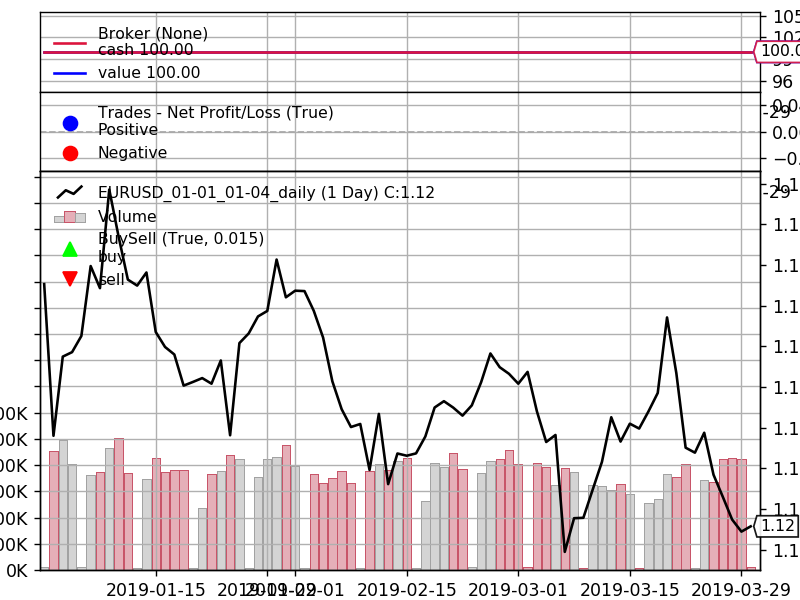

Final Portfolio Value: 100.00
Final Portfolio Value: $100.0
P/L: $0.0


In [9]:
    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Plot the result
    cerebro.plot()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    portvalue = cerebro.broker.getvalue()
    pnl = portvalue - startcash

    print('Final Portfolio Value: ${}'.format(portvalue))
    print('P/L: ${}'.format(pnl))